# Larval fish recruitment behavior in Hawaii

- Release dates = 1 March 2010 - 30 April 2010, 100 larval-fish daily from each release location (61 days)
- Duration simulation = 1 March 2010 - 15 June 2010 (107 days)

## Understanding “recruitment behavior”/“settlement behavior”
For a particle to be considered “recruited”, it has to be within a 5 km radius of the release sites on day 45. If the particle settles, stop the particle and flag it. The goal is to know how many baby fish (particles) come back to where they came from. That percentage is important to know if fish population in Hawaii will be sustainable.

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
from datetime import timedelta
import numpy as np
from scipy.io import netcdf
from netCDF4 import Dataset
import pandas as pd

from mpl_toolkits.basemap import Basemap

import csv
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle as pickle

import time

filenames = {'U': "../MITgcm_data/UV*.cdf",
             'V': "../MITgcm_data/UV*.cdf"}

In [2]:
import parcels
print(parcels.__file__)
from parcels import rng as random
import math

/Users/mho/anaconda3/envs/py2_parcels/lib/python2.7/site-packages/parcels/__init__.pyc


In [3]:
variables = {'U': 'U',
             'V': 'V'}
dimensions = {'time': 'TIME1','depth': 'DEPTH_T1_4',
              'lat': 'LATITUDE_T',
              'lon': 'LONGITUDE_U'}

In [4]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [26]:
def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()

In [27]:
def turbVal(particle, fieldset, time, dt):
    # This if-statement is meant to trigger when the current time is a quarter interval of the model timestep
    # but I'm not sure it's working... need to double-check
    if math.fmod(time,dt/4) == 0:
        horDiff = 100
        uturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1) # Important! Should this be random.random()???
        # should set random seed somewhere too...?
        particle.lat += uturb * dt/1.1e5
        vturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1)
        particle.lon += vturb * dt/1.1e5

In [10]:
# release locations

release_locations = pd.read_csv('ReefCellData_for_Johanna_23June2014.csv', header=None, names=['value','name','code','latitude','longitude'])

In [11]:
release_locations.head()

,value,name,code,latitude,longitude
0,0.066875,Kure Atoll,NOAA NCCOS,28.501778,-178.369614
1,0.015000,Kure Atoll,NOAA NCCOS,28.501778,-178.261817
2,0.115000,Kure Atoll,NOAA NCCOS,28.470031,-178.369614
3,0.237500,Kure Atoll,NOAA NCCOS,28.470031,-178.261817
4,0.266250,Kure Atoll,NOAA NCCOS,28.438274,-178.369614


In [23]:
release_locations.name.unique()

array(['Kure Atoll', 'Midway Islands', 'Pearl and Hermes Atoll',
       'Lisianski Island', 'Pioneer Bank', 'Laysan Island',
       'Laysan West pinnacle', 'Raita Bank', 'Maro Reef',
       'Laysan South Pinnacle', 'Gardner Pinnacles',
       'Bank west of St. Rogatien Bank', 'St. Rogatien Bank',
       'St. Rogatien SE Bank 1', 'St. Rogatien SE Bank 2',
       'St. Rogatien SE Bank 3', 'French Frigate Shoals', 'Necker Island',
       'Nihoa Island', 'NW Main Hawaiin Bank 1', 'NW Main Hawaiin Bank 2',
       'Kaula', 'Johnnston Atoll', 'Kauai', 'Niihau', 'Oahu', 'Molokai',
       ' ', 'Mauai', 'Lanai', 'Kahoolawe', 'Hawaii'], dtype=object)

In [13]:
lat = release_locations['latitude']
lon = release_locations['longitude']

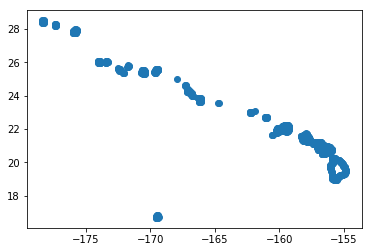

In [20]:
plt.scatter(lon, lat)

In [16]:
# How many times to repeat
npart = 100

In [25]:
#Release from the same set of locations every day
repeatdt = timedelta(days=1)  
pset = ParticleSet(fieldset=fieldset,
                   pclass=JITParticle,
                   lon=np.tile(lon,npart),
                   lat=np.tile(lat,npart),
                   repeatdt=repeatdt)

In [28]:
k_turbVal = pset.Kernel(turbVal)        # casting the turbVal function to a kernel object

In [37]:
# release from March 1 - April 30
# track until June 15th

now = time.time()

# Set random seed
random.seed(123456)

days = 10
runtime = timedelta(days=days)

output_file = pset.ParticleFile(name="{}days_repeated_100release".format(days), outputdt=timedelta(days=1))

pset.execute(AdvectionRK4 + k_turbVal,
             runtime=runtime,
             dt=timedelta(hours=1),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=output_file)

time_elapsed = time.time()-now
print('time elapsed (s): ', time_elapsed)

INFO: Compiled JITParticleAdvectionRK4turbVal ==> /var/folders/nj/pymsyw7n28qdntb958tl337c0000gp/T/parcels-502/29259c4ff9fd60c10670c010d29b6008.so


KeyboardInterrupt: 

In [36]:
plotTrajectoriesFile("{}days_repeated_100release.nc".format(days),mode='movie2d_notebook')

KeyboardInterrupt: 

In [6]:
# PLOT WITH BASEMAP AND BATHYMETRY DATA

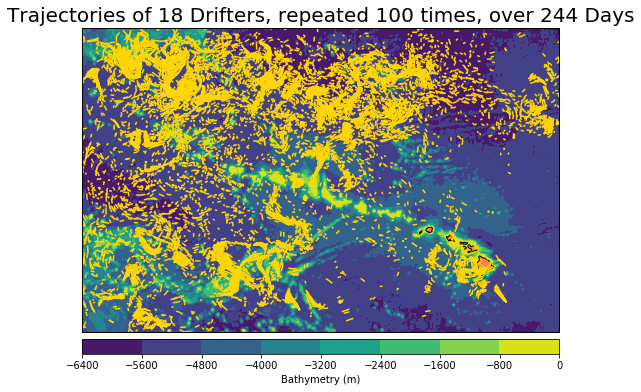

In [21]:
pfile = Dataset('18n_Turbulence_100repeats_244days.nc', 'r')
bath_data = Dataset('../HAWc0.04_depth.cdf')

# For determining the boundaries of the basemap
lon = pfile.variables['lon']

# print('min long: ', np.nanmin(lon))
# print('max long: ', np.nanmax(lon))

lat = pfile.variables['lat']
# print('min lat: ', np.nanmin(lat))
# print('max lat: ', np.nanmax(lat))

# Set up the figure, change figsize as needed
plt.figure(figsize=(12,6))

# Set up mapper with a Basemap of coastal boundaries for Hawaii
mapper = Basemap(projection='merc',
                 llcrnrlon=np.nanmin(lon),
                 llcrnrlat=np.nanmin(lat),
                 urcrnrlon=np.nanmax(lon),
                 urcrnrlat=np.nanmax(lat),
                 resolution='i')
mapper.drawmapboundary()
mapper.drawcoastlines()
mapper.fillcontinents(color='coral',lake_color='aqua')

# plot each trajectory separately, in gold color
# documentation: https://matplotlib.org/basemap/index.html
for i in range(lon.shape[0]):
    lons = lon[:][i]
    lats = lat[:][i]
    mapper.plot(np.array(lons), np.array(lats), latlon=True, color='gold')

    
# Plot 18 origin points

origin_lat = [31.082, 29.152, 32.794, 30.900, 27.781, 27.952, 18.640, 29.661, 24.174, 21.020, 34.102, 33.462, 31.458, 32.024, 15.509, 18.906, 17.074, 16.555]
origin_lon = [176.366, 191.072, 197.52, 193.91, 178.991, 194.899, 178.040, 208.099, 191.298, 187.602, 188.077, 181.109, 183.82, 179.190, 180.468, 189.375, 206.097, 190.914]
mapper.scatter(origin_lon, origin_lat, latlon=True, c='red', marker='o', s=20)

# Set up processing for bathymetry data
lats = bath_data.variables['Y_B'][:]
lons = bath_data.variables['X_B'][:]
BATHY_OUT = bath_data.variables['BATHY_OUT'][:] # etopo1 bedrock global relief model-topography/bathymetry (m)

lons,lats= np.meshgrid(lons,lats)
x,y = mapper(lons,lats)

# Create contour object and add to the mapper
depth = mapper.contourf(x,y,BATHY_OUT[0])

# Add legend
cb = mapper.colorbar(depth,"bottom", size="5%", pad="2%")
cb.set_label('Bathymetry (m)')

# Change plot titles
plt.title('Trajectories of 18 Drifters, repeated 100 times, over 244 Days', fontsize=20)
plt.savefig('n18_r100_d244_2.png')

plt.show()